In [ ]:
##imports and setup
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras.backend as KB
from keras.preprocessing.image import ImageDataGenerator, load_img, NumpyArrayIterator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model
import cv2 as cv
import keras
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


#mount drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change data_src variable as per your drive
data_src = '/content/drive/MyDrive/Colab/AffectNet'

#Loading the data into the correct format:
train_faces = np.load(data_src+'/training_images_64.npy')
#normalizing
train_annotations =(np.load(data_src+'/training_annotations_64.npy')+1)/2

print(train_faces.shape)
print(train_annotations.shape)
print('completed')

(84989, 64, 64, 3)
(84989, 2)
completed


In [ ]:
## Putting the data into training classes:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(train_faces, train_annotations, test_size=0.01, shuffle=True)

batch_size=64
#### Fit the dataset
train_datagen = ImageDataGenerator(rescale=1./255,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

training_set=train_datagen.flow(x_train,y_train,batch_size=batch_size)


val_datagen = ImageDataGenerator(rescale=1./255,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

val_set=val_datagen.flow(x_valid,y_valid,batch_size=batch_size)

print('completed')

completed


In [ ]:
### model setup
#data size 128
IMG_SIZE = 64
IMG_DIM =3

def model_vgg13_custom( output_classes=2):
    model = tf.keras.models.Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DIM)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Faltten the model
    model.add(Flatten())

    model.add(Dense(1024))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.50))

    model.add(Dense(1024))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.50))

    #Sigmoid Activation function
    model.add(Dense(output_classes, activation='sigmoid'))
    #Mean Squared Error loss function The metric must be different in regression cases.

    print(model.summary())
    return model
model=model_vgg13_custom()
print('completed')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0

In [ ]:
### CCC implementations

import tensorflow.keras.backend as K

def ccc_loss(y_true, y_pred):
    return 1 - ((ccc_v(y_true, y_pred) + ccc_a(y_true, y_pred)) / 2)


def ccc_v(y_true, y_pred):
    """
    Concordance Correlation Coefficient for valence
    """
    x = y_true[:, 0]
    y = y_pred[:, 0]
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    rho = K.sum(xm * ym) / (K.sqrt(K.sum(xm ** 2)) * K.sqrt(K.sum(ym ** 2)))
    x_s = K.std(x)
    y_s = K.std(y)
    ccc = 2 * rho * x_s * y_s / (x_s ** 2 + y_s ** 2 + (mx - my) ** 2)
    return ccc


def ccc_a(y_true, y_pred):
    """
    Concordance Correlation Coefficient for arousal
    """
    x = y_true[:, 1]
    y = y_pred[:, 1]
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    rho = K.sum(xm * ym) / (K.sqrt(K.sum(xm ** 2)) * K.sqrt(K.sum(ym ** 2)))
    x_s = K.std(x)
    y_s = K.std(y)
    ccc = 2 * rho * x_s * y_s / (x_s ** 2 + y_s ** 2 + (mx - my) ** 2)
    return ccc

print('completed')
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(optimizer=opt, loss=ccc_loss, metrics=[ccc_v, ccc_a])
print('completed')

completed
completed


In [ ]:
###making the training ready
chk_path = '/content/drive/MyDrive/Colab/AffectNet/vgg13t_affectnet1.h5'
log_dir = "/content/drive/MyDrive/Colab/AffectNet/checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                               save_best_only=True,
                               verbose=1,
                               mode='min',
                               moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=3,
                            verbose=1,
                            restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=6,
                                verbose=1,
                                min_delta=0.0001)

steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = val_set.n // val_set.batch_size

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('/content/drive/MyDrive/Colab/AffectNet/training_AffectNet_vgg13t1.log')

callback = [checkpoint, reduce_lr, csv_logger]
print(steps_per_epoch)
print(validation_steps)

print('completed')

1062
265
completed


In [ ]:
with tf.device('/device:GPU:0'):
  epochs=30
  model_hist = model.fit(x=training_set,
                  validation_data=val_set,
                  epochs=epochs,
                  callbacks=callback,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)
#save_path = '/content/drive/MyDrive/Colab/afew/vgg13_affectnet_finished.h5'
#model.save_weights(save_path)

Epoch 1/30
1062/1062 [==============================] - 107s 101ms/step - loss: 0.7409 - ccc_v: 0.3916 - ccc_a: 0.1263 - val_loss: 0.5630 - val_ccc_v: 0.6288 - val_ccc_a: 0.2452

Epoch 00001: val_loss improved from inf to 0.56303, saving model to /content/drive/MyDrive/Colab/AffectNet/vgg13t_affectnet1.h5
Epoch 2/30
1062/1062 [==============================] - 106s 100ms/step - loss: 0.5234 - ccc_v: 0.6525 - ccc_a: 0.3006 - val_loss: 0.4799 - val_ccc_v: 0.6868 - val_ccc_a: 0.3535

Epoch 00002: val_loss improved from 0.56303 to 0.47989, saving model to /content/drive/MyDrive/Colab/AffectNet/vgg13t_affectnet1.h5
Epoch 3/30
1062/1062 [==============================] - 106s 100ms/step - loss: 0.4729 - ccc_v: 0.6888 - ccc_a: 0.3653 - val_loss: 0.4601 - val_ccc_v: 0.7035 - val_ccc_a: 0.3763

Epoch 00003: val_loss improved from 0.47989 to 0.46009, saving model to /content/drive/MyDrive/Colab/AffectNet/vgg13t_affectnet1.h5
Epoch 4/30
1062/1062 [==============================] - 106s 100ms/step

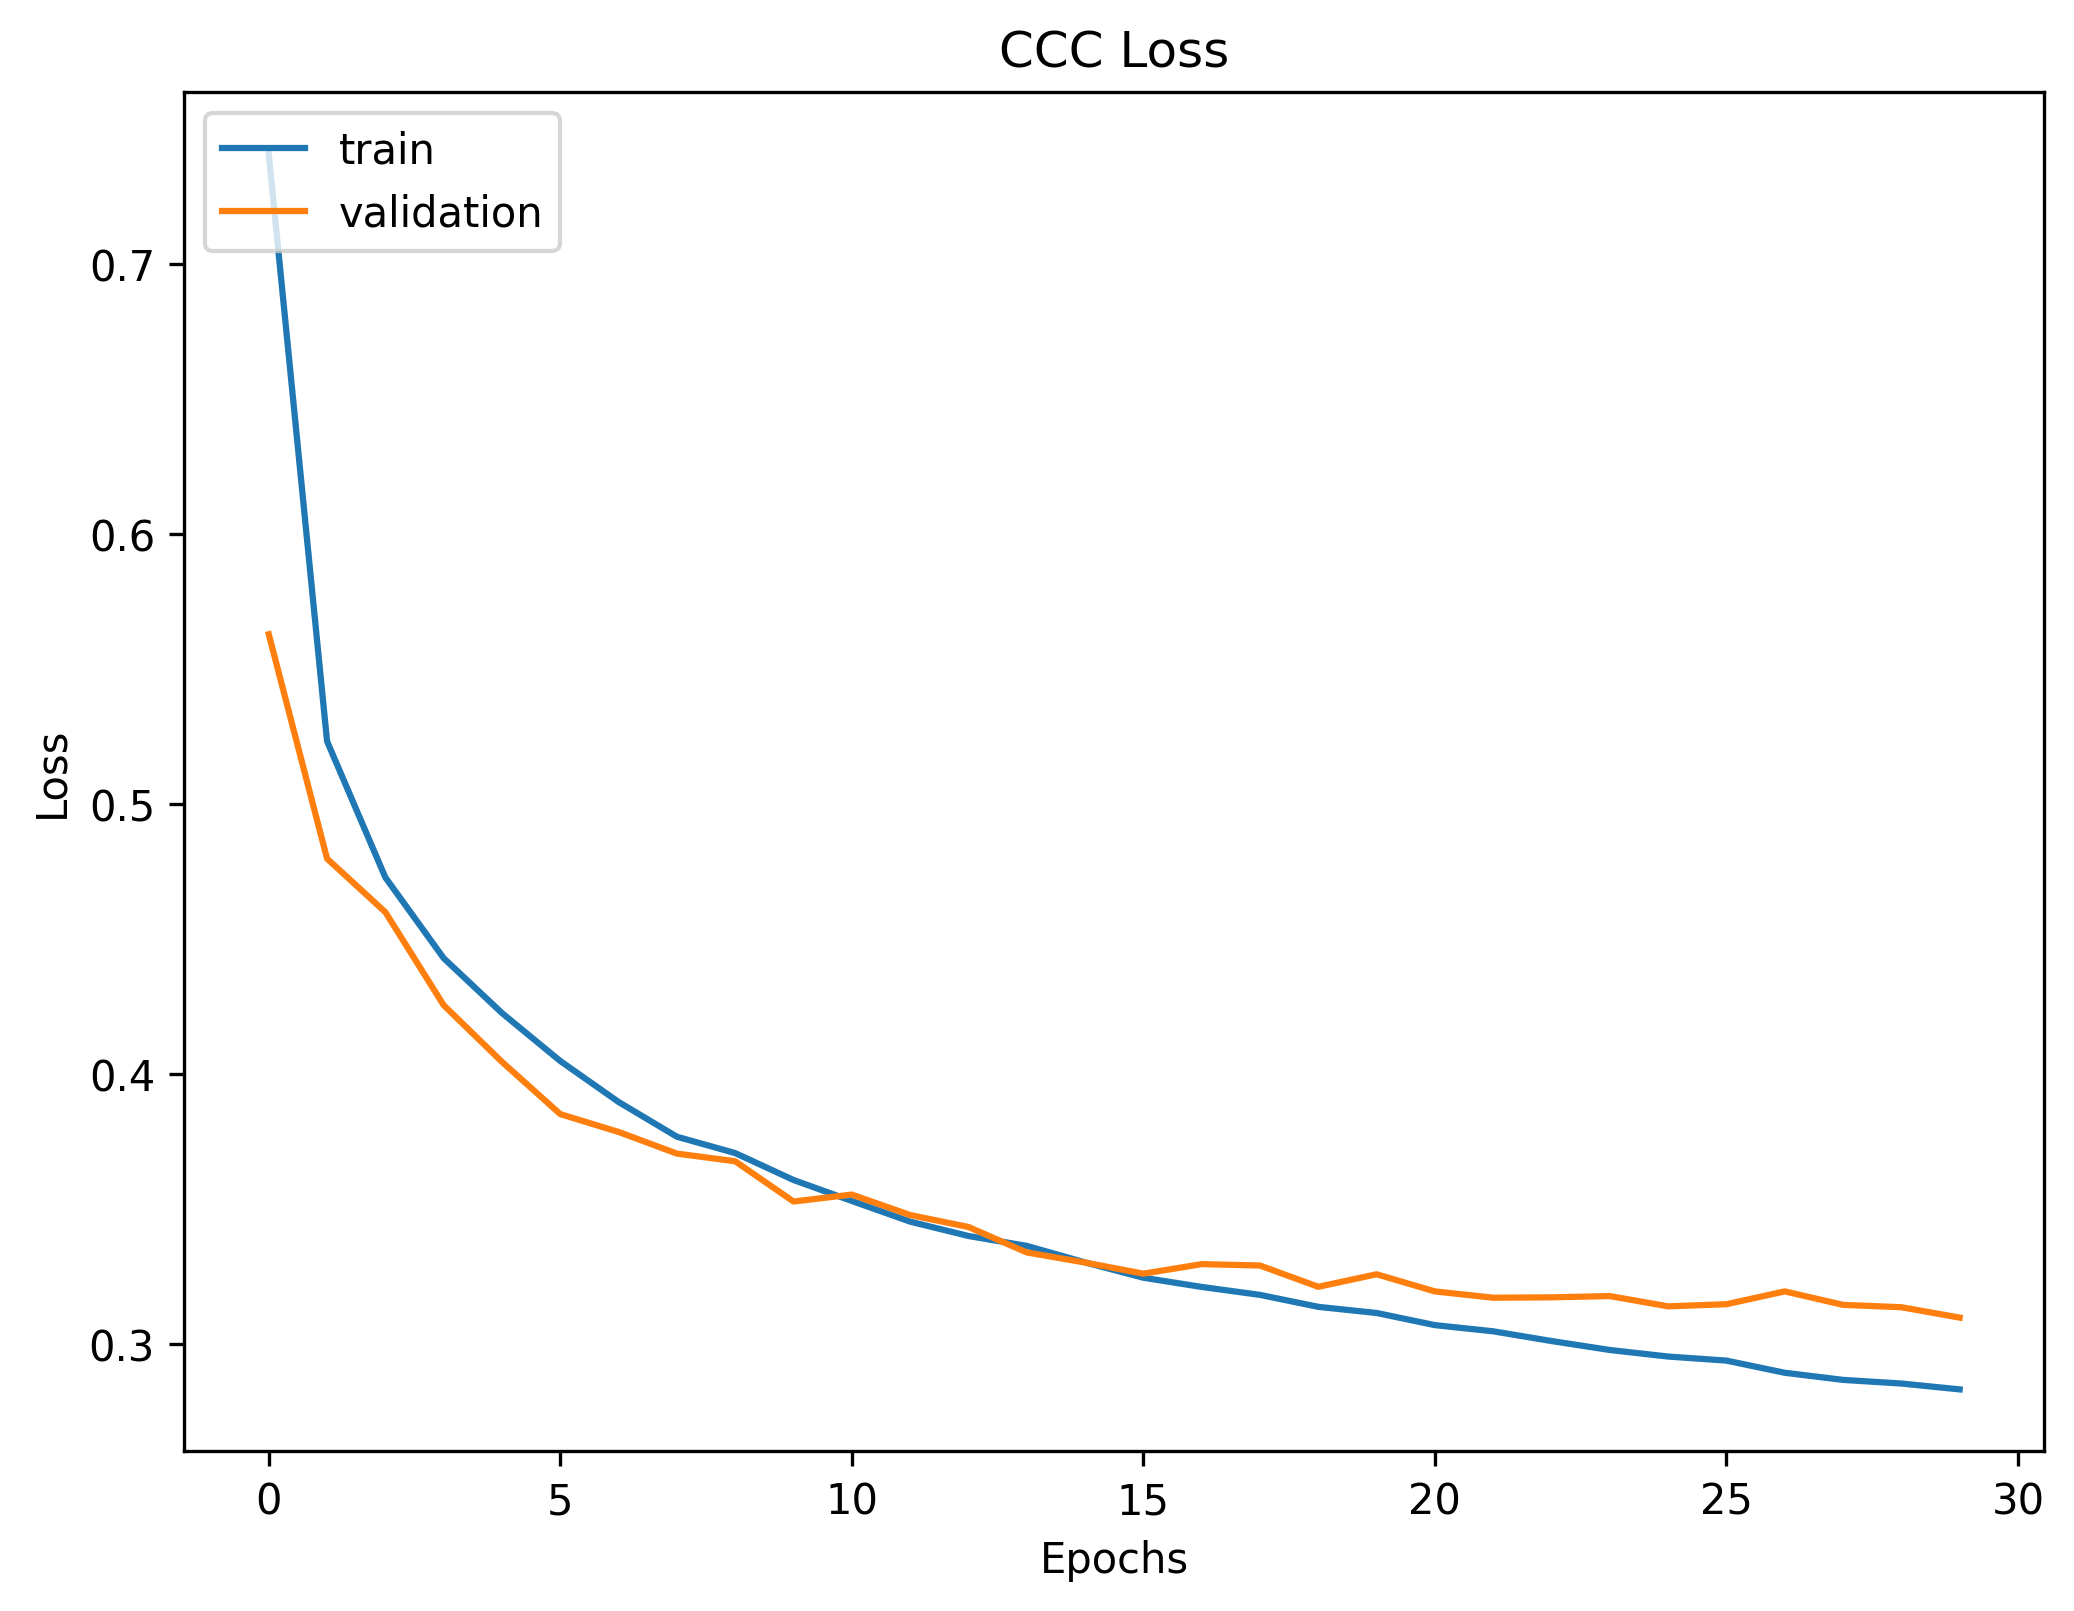

<Figure size 1800x1200 with 0 Axes>

In [ ]:
###Results for the model
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(8,6))
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('CCC Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig("/content/drive/MyDrive/Colab/AffectNet/results_vgg13_affectnet_loss.png")

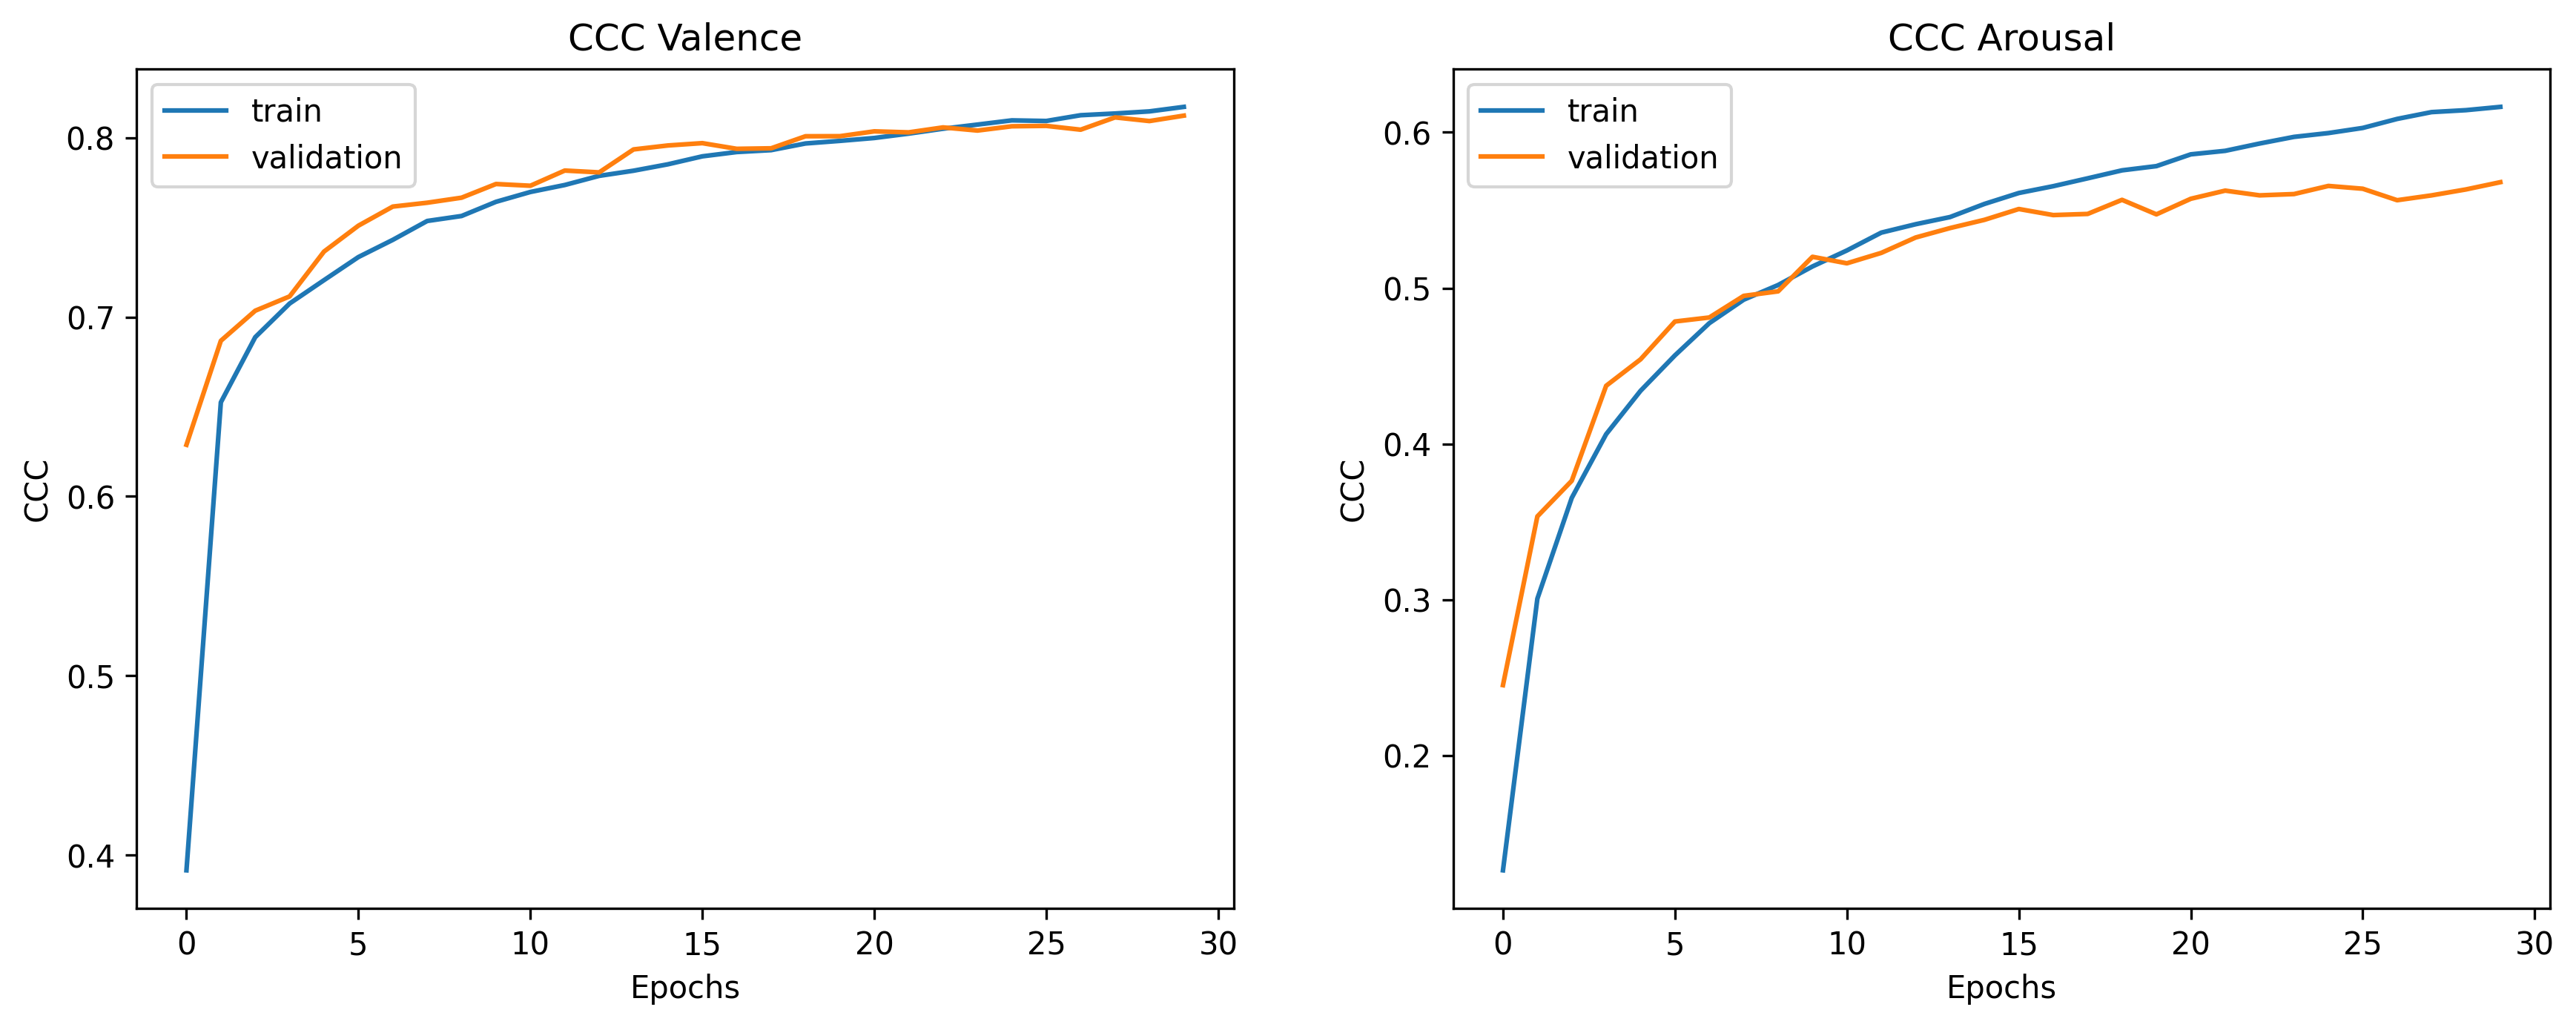

<Figure size 1800x1200 with 0 Axes>

In [ ]:
###Results for the model
### PLOTTING OF CCC SCORE
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)

plt.plot(model_hist.history['ccc_v'])
plt.plot(model_hist.history['val_ccc_v'])
plt.title('CCC Valence')
plt.xlabel('Epochs')
plt.ylabel('CCC')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(model_hist.history['ccc_a'])
plt.plot(model_hist.history['val_ccc_a'])
plt.title('CCC Arousal')
plt.xlabel('Epochs')
plt.ylabel('CCC')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig("/content/drive/MyDrive/Colab/AffectNet/results_vgg13_affectnet.png")

In [ ]:
##Loading weigths 
PATH="/content/drive/MyDrive/Colab/AffectNet/"
# Load the previously saved weights
model.load_weights(PATH+'vgg13t_affectnet.h5')

#Loading the Data_set
# Change data_src variable as per your drive
data_src = '/content/drive/MyDrive/Colab/AffectNet'

#Loading the data into the correct format:
test_faces = np.load(data_src+'/validation_images_64.npy')/255
test_labels = (np.load(data_src+'/validation_annotations_64.npy')+1)/2
#Only for grayscale.
#from sklearn.model_selection import train_test_split
print(test_labels)
#x_test, _, y_test, _ = train_test_split(train_faces, train_labels, test_size=0.10, shuffle= True)


print('completed')

[[0.411577   0.4611801 ]
 [0.3161055  0.5919475 ]
 [0.46854435 0.7661635 ]
 ...
 [0.23545    0.853836  ]
 [0.3492065  0.6190475 ]
 [0.362079   0.7951995 ]]
completed


In [ ]:
print("Evaluate on test data")

results = model.evaluate(test_faces, test_labels, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
63/63 [==============================] - 2s 26ms/step - loss: 0.5074 - ccc_v: 0.5011 - ccc_a: 0.4846
test loss, test acc: [0.5074101686477661, 0.5011192560195923, 0.48464035987854004]


In [ ]:
def extract_face(frame ):
    # extracting face and body and outputs tensor # add size of output image
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 6)
    # extract ROIS
    if type(faces) is tuple:
        return False
    for (x, y, w, h) in faces:
        # cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        ##simple scalings...
        temp = y - int(h / 3)
        if y - int(h / 3) < 0:
            temp = 0
        roi = frame[y:y + h, x:x +w]
    dim = (64, 64)
    resized = cv.resize(roi, dim, interpolation=cv.INTER_AREA)/255
    # print(resized.shape)
    cv2_imshow(cv.resize(roi, (224,224), interpolation=cv.INTER_AREA))
    return resized
print("completed")

completed


In [ ]:
##Loading weigths 
PATH_WEIGHTS="/content/drive/MyDrive/Colab/AffectNet/vgg13_affectnet.h5"
# Load the previously saved weights
model.load_weights(PATH_WEIGHTS)
print('completed')

completed


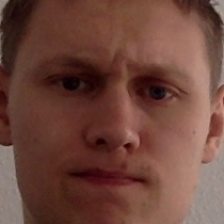

[[-0.46756196  0.38922083]]


In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow
##Testing

PATH_IMAGE = "/content/drive/MyDrive/Colab/emotion_pics/"
image = "angry.jpg"
frame=cv.imread(PATH_IMAGE+image)
img=extract_face(frame)
#cv2_imshow(img)
#test=training_set.next()[0]
#labeled=training_set.next()[1]
#print(train_cont)
#print(train_faces)
#print(img)

predicted=model.predict(img[None,...])
#print(predicted)
#print(train_cont[6])
predicted=predicted*2-1
print(predicted)


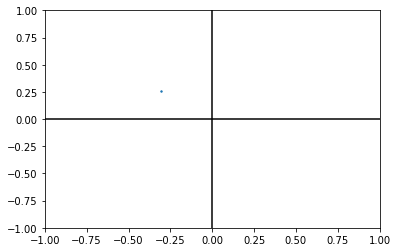

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.scatter(predicted[0][0],predicted[0][1],s=2)
fig.show()